In [1]:
import os, sys
import glob
import json
import string

import datetime as dt

import numpy as np
import xarray as xr
import pandas as pd
import networkx as nx

import geopandas as gpd
from shapely.affinity import affine_transform

import seaborn as sns
import matplotlib as mpl

from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt

project_root = os.path.abspath(os.pardir)
python_path = os.path.join(project_root, "python")
sys.path.append(python_path)

from plotutils import *
from metricutils import *

In [2]:
# Custom parameters for the plots
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="whitegrid", palette="deep", rc=custom_params)

In [3]:
############################
# Loading all the data need
############################

layer               = "cnig_provincias"
run_id              = "run_ETE_w28_d14_S_Q1_-1_Q2_1_risk_ij"
experiments_folder  = "../outputs/"

output_folder       = os.path.join(experiments_folder, f"TE_{layer}/")
config_fname        = os.path.join(output_folder, "config.json")

te_run_folder       = os.path.join(output_folder, run_id)
te_output_fname     = os.path.join(te_run_folder, "TE.nc")
te_params_fname     = os.path.join(te_run_folder, f"params.json")

print(config_fname)
with open(config_fname) as fh:
    config = json.load(fh)


population_ds_fname = config["cases_ds_fname"]
mobility_ds_fname  = config["risk_ds_fname"]

with open(te_params_fname) as fh:
    te_params = json.load(fh)
    te_params = te_params['te_params']

Txy           = xr.load_dataarray(te_output_fname)
TSxy          = calculate_net_TSxy(Txy)
population_ds = xr.load_dataset(os.path.join(experiments_folder, f"TE_{layer}/cases_pop_ds.nc"))
mobility_ds   = xr.load_dataset(os.path.join(experiments_folder, f"TE_{layer}/risk_ds.nc"))
te_x_varname  = te_params["TE_x"]
te_y_varname  = te_params["TE_y"]
date_range    = Txy.coords['date'].values


# Creating geopandas dataframe to plot the maps
data_folder = os.path.join(project_root, config["data_folder"])
geojson_fname  = os.path.join(data_folder, f"{layer}.geojson")
gdf_patches = gpd.read_file(geojson_fname)
gdf_patches.set_index('id', inplace=True)
gdf_patches['centroid'] = gdf_patches['geometry'].apply(lambda x: x.centroid)
gdf_patches = gdf_patches[~gdf_patches.index.isin(config['filter_patches'])]
gdf_patches = gdf_patches.sort_index()

../outputs/TE_cnig_provincias/config.json


21.42301644378732
21.42301644378732
21.42301644378732
41.170094586934816
41.170094586934816
41.170094586934816
43.133331989300466
43.133331989300466
43.133331989300466


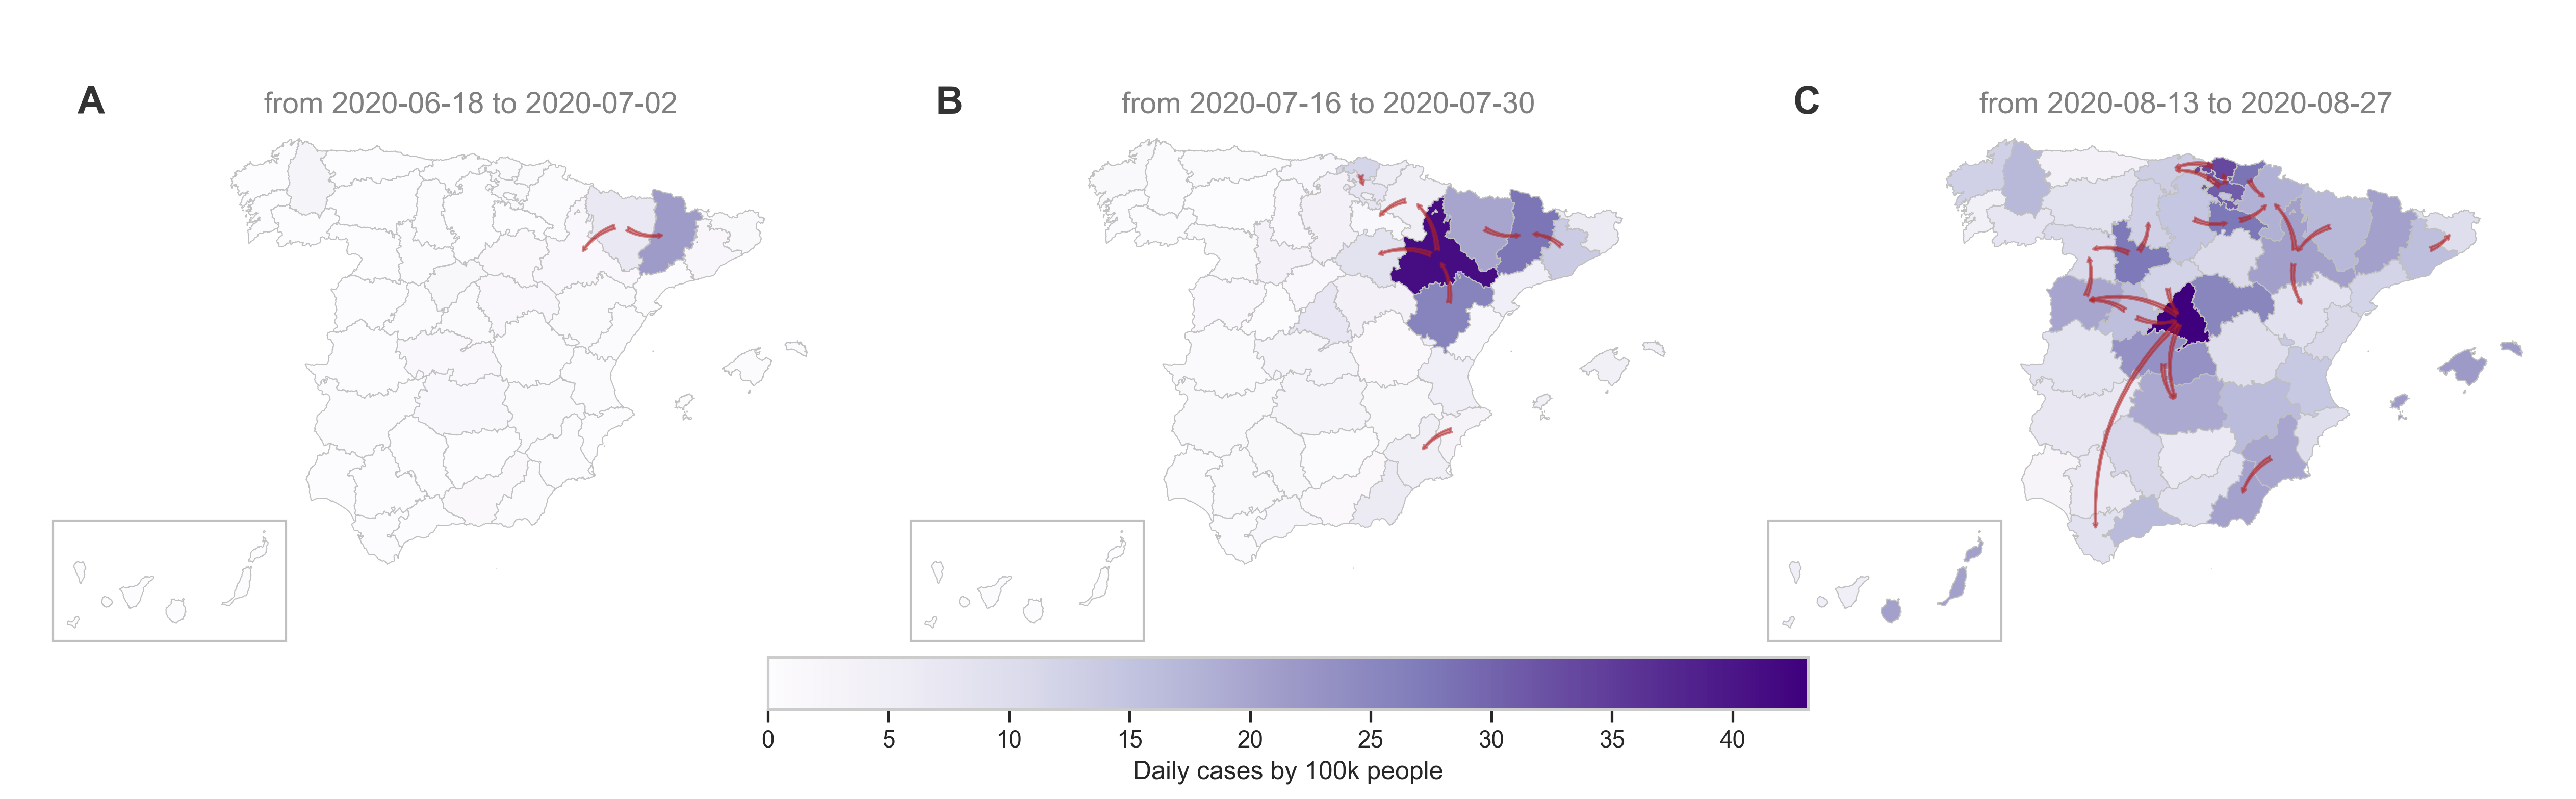

In [14]:
omega = 14
n_dates = 6
start = 123
my_dates = np.array(range(start,start+omega*n_dates,omega))[[0,2,4]]
my_dates = [110, 138, 166]
my_dates2 = [date_range[i] for i in my_dates] # getting the proper dates


cases = population_ds["new_cases_by_100k"].to_pandas().unstack() #.rolling(14).mean().unstack()
cases.name = "Cases by 100 individuals"
cases_tab = cases.unstack()
column = cases.name
vmax = cases.loc[my_dates2].max()

#cases_sel = cases.loc[cases.index.get_level_values(1).isin(sel_ids)]
#Txy_sel = Txy.loc[sel_ids, sel_ids, :]

fig, axes = plt.subplots(1, 3, figsize=(17, 7), dpi=300, sharex=True, sharey=True)
fig.set_facecolor('white')
i = 0
for idx in my_dates:
    # Merging the data column for a date in th geopandas dataframe
    # to colour the regions (here using new_cases_by_100k)
    date = date_range[idx]
    data = cases.loc[date]
    print(data.max())
    gdf = pd.merge(gdf_patches, data, left_index=True, right_index=True)
    gdf = gdf[[column, 'geometry', 'centroid']].copy()
    
    d_star = date - np.timedelta64(te_params["omega"],'D')
    delta_cases =  cases_tab.loc[date] - cases_tab.loc[d_star]
    
    fil = TSxy.loc[:,:,date]
    fil = fil.where(fil > 0)
    fil = fil.quantile(0.95).values
    print(data.max())
    G = create_TSxy_network(Txy, data, date, thr_filter=fil)
    
    for (u,v) in G.edges:
        if delta_cases[v] > 0:
            G[u][v]['color'] = "firebrick"
        elif delta_cases[v] < 0:
            G[u][v]['color'] = "green"
        else:
            G[u][v]['color'] = "white"
    
    ax = axes[i]
    ax.set_facecolor('white')
    print(data.max())
    plot_map_net(ax, gdf, G, column, data, date, layer, vmax=vmax)
    ax.text(0.075, 1, string.ascii_uppercase[i], fontsize=18, 
            transform=ax.transAxes, weight='bold', color='#333333')
    ax.text(0.3, 1, f"from {str(date_range[idx-14])[:10]} to {str(date)[:10]}", fontsize=14, 
            transform=ax.transAxes, color='grey')
    i += 1

fig.subplots_adjust(wspace=0, hspace=0)
fig.tight_layout()

cbar_ax = fig.add_axes([0.3, 0.05, 0.4, 0.8])
cmap = sns.color_palette("Purples", as_cmap=True)
norm = mpl.colors.Normalize(vmin=0, vmax=vmax)
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), 
                    fraction=0.25, pad=0.05, ax=cbar_ax, orientation="horizontal")

cbar.set_label("Daily cases by 100k people", loc='center')
cbar_ax.set_axis_off()

fig.savefig("../figures/main/Figure5.tiff", dpi=300)

In [11]:
my_dates = [120, 148, 176]

array([123, 151, 179])